In [564]:
# SimpleFieldGen_Coax_MultipleEpsilons
# Ren Cooper, LBNL
# Gamma-Ray Tracking School, ORNL, October 2018
#
# very simple Potential solver for a coaxial HPGe detector via SOR method
#
#  - 2D, radial symmetry around core
#  - does not handle depletion
#  - handles multiple dielectrics but is a work in progress!
#    (http://www.ece.utah.edu/~ece6340/LECTURES/Feb1/Nagel%202012%20-%20Solving%20the%20Generalized%20Poisson%20Equation%20using%20FDM.pdf)

In [565]:
%matplotlib inline
%reset -f

In [566]:
import numpy as np
from matplotlib import pyplot as plt

In [567]:
# set some detector parameters
detector_length_mm = 90.0
detector_radius_mm = 40.0
pixel_size_mm = 1.0

core_length_mm = 40.0
core_radius_mm = 12.0

wrap_around_mm = 10.0

outer_contact_bias = 1000.0
core_contact_bias = 0.0

charge_density_zero = 2.0
charge_density_gradient = 0.5

In [568]:
# build (uniform) 2D grids for plotting and solving
x_range = np.arange(0, detector_radius_mm + pixel_size_mm, pixel_size_mm)
y_range = np.arange(0, detector_length_mm + pixel_size_mm, pixel_size_mm)

# for solving
N_xelements = np.shape(x_range)[0]
N_yelements = np.shape(y_range)[0]
V = np.zeros((N_xelements, N_yelements), dtype=float)


In [569]:
# build a little map of geometry for later
# Ge = 0, outer contact = 1, core = 2, passivated face = 3
geom_map = np.zeros((N_xelements, N_yelements), dtype=int)

# outer contact
geom_map[(N_xelements-1),:] = 1
geom_map[:,(N_yelements-1)] = 1

# outer contact wrap around
ix = np.where(x_range>=(detector_radius_mm-wrap_around_mm))
geom_map[ix,0] = 1

# control the passivated back face if you like
#ix = np.where((x_range>core_radius_mm) & (x_range<(detector_radius_mm-wrap_around_mm)))
#geom_map[ix,0] = 3

In [570]:
# set up charge distribution through xtal
charge = np.zeros((N_xelements, N_yelements), dtype=float)
epsilon = np.zeros((N_xelements, N_yelements), dtype=float)
pixels_to_cm = 10/pixel_size_mm

for x in range(0, N_xelements):
    for y in range(0, N_yelements):
        charge[x,y] = charge_density_zero + charge_density_gradient*(y/pixels_to_cm)
        epsilon[x,y] = 16.0
        
        # core
        if (x_range[x]<core_radius_mm and y_range[y]<core_length_mm):
            charge[x,y] = 0.0
            geom_map[x,y] = 2
            epsilon[x,y] = 1.0


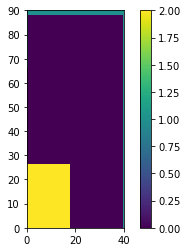

In [571]:
# view the geometry
plt.contourf(geom_map)
ax = plt.axes()
plt.minorticks_on()
plt.grid("on")
plt.xlabel('Pixel #')
plt.ylabel('Pixel #')
plt.show()

In [572]:
# set boundary conditions and initial guess at solution

# initial guess at solution
for x in range(0, N_xelements):
    for y in range(0, N_yelements):
        V[x,y] = outer_contact_bias*x / N_xelements

# outer contact
x,y = np.where(geom_map==1)
V[x,y] = outer_contact_bias

# core
x,y = np.where(geom_map==2)
V[x,y] = core_contact_bias

# pssivated back face
#x,y = np.where(geom_map==3)
#V[x,y] = 0.0 

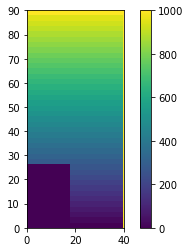

In [573]:
# inspect the intial conditions for V
plt.contourf(V,100,interpolation="None")
plt.grid("on")
plt.xlabel('Pixel #')
plt.ylabel('Pixel #')
plt.colorbar()

In [574]:
# do the relaxation
e0 = 8.85e-12

# set maximum number of iterations
max_iters = 1000

# relaxation factor to speed up convergence
t = np.cos(3.14/N_xelements) + np.cos(3.14/N_yelements)
w = (8 - np.sqrt(64 - 16*t*t)) / (t*t)

# convert charge to C/m
charge = charge * (pixel_size_mm*pixel_size_mm) * 1.6e-19

# initialise a couple of arrays
R = np.zeros((N_xelements, N_yelements), dtype=float)
resid_store = np.zeros(max_iters)

depletion_map = np.ones((N_xelements, N_yelements), dtype=int)

# perform relaxation...
resid = 1e6
iterr = 1
min_resid = 0.01
while (iterr < max_iters and resid > min_resid):    
    
    # loop over detector grid points
    for y in range(0, N_yelements):
        for x in range(0, N_xelements):
                        
            # skip non-Ge
            if (geom_map[x,y] != 0):
                continue
            
            # calculate coefficients
            a0 = epsilon[x,y] + epsilon[x-1,y] + epsilon[x,y-1] + epsilon[x-1,y-1]
            a1 = 0.5*(epsilon[x,y] + epsilon[x,y-1])
            a2 = 0.5*(epsilon[x-1,y] + epsilon[x,y])
            a3 = 0.5*(epsilon[x-1,y-1] + epsilon[x-1,y])
            a4 = 0.5*(epsilon[x,y-1] + epsilon[x-1,y-1])
            
            # calculate sum of forward pixels which we will then add to
            V_local_sum = a1*V[x+1,y] + a2*V[x,y+1]

            Vmin = min(V[x+1,y], V[x,y+1])
            
            if (y > 0):
                V_local_sum += a4*V[x,y-1]
                Vmin = min(Vmin, V[x,y-1])
            else:
                V_local_sum += a2*V[x,y+1]
                
            if (x > 0):
                V_local_sum += a3*V[x-1,y]
                Vmin = min(Vmin, V[x-1,y])
            else:
                V_local_sum += a1*V[x+1,y]
            
            # calculate residual and update
            charge_term = (charge[x+1,y] + charge[x,y+1] + charge[x-1,y] + charge[x,y-1])*pixel_size_mm*pixel_size_mm
            R[x,y] = (1/a0)*(V_local_sum + charge_term/e0) - V[x,y]
            
            # update potential
            V[x,y] = V[x,y] + w*R[x,y]
            
            #if (V[x,y] < Vmin):
            #    V[x,y] = Vmin
            #    depletion_map[x,y] = 0
            
    # store and residual
    resid = abs(np.sum(R))
    resid_store[iterr] = resid
    
    # update iteration counter
    iterr+=1


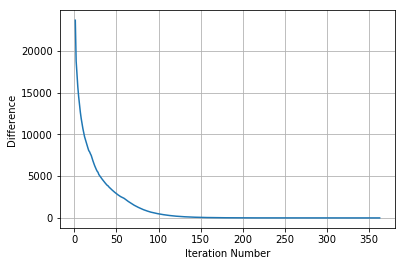

Final Difference:
0.00969159564676


In [575]:
resid_store = resid_store[1:iterr]
plt.plot(np.arange(1,iterr), resid_store)
plt.grid("on")
plt.xlabel("Iteration Number")
plt.ylabel("Difference")
plt.yscale("log")
plt.show()

print("Final Difference:")
print(resid_store[-1])


In [576]:
# mirror symmetry around x = 0
Vfinal = np.flipud(V)
Vfinal = np.append(Vfinal, V, axis=0)

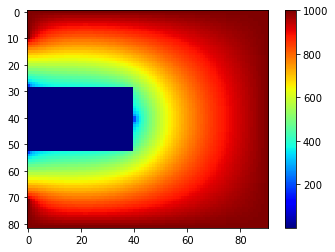

In [577]:
# plot potential
plt.imshow(Vfinal, interpolation="None", cmap="jet", vmin=0.1)
plt.colorbar()

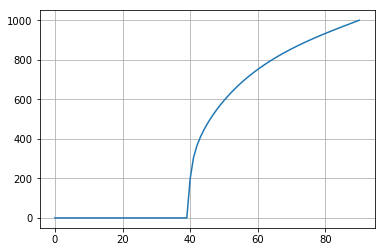

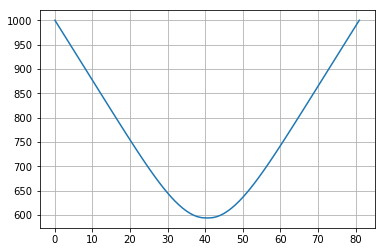

In [578]:
# plot potential/field slices
x_slice = 40
y_slice = 50


plt.plot(Vfinal[x_slice,:])
plt.grid("on")
plt.show()

plt.plot(Vfinal[:,y_slice])
plt.grid("on")
plt.show()